In [1]:
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from plotting_helper import * 


figures_path = 'figures/'
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  


/home/patricia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
VDP_eq = '''
    dglutamate/dt = - glutamate/tau_glutamate : 1 (clock-driven)
    sig_LTP = 1/(1+exp(k_LTP*(-(v - theta_NMDA)+0*mV))) : 1 (constant over dt)
    dv_NMDA_rise/dt = (-v_NMDA_rise + clip(clip(sig_LTP - v_NMDA,0,100) - v_NMDA_rise,0,100))/tau_NMDA_rise : 1 (clock-driven)             
    dv_NMDA/dt = (NMDA_amp * v_NMDA_rise - v_NMDA)/tau_NMDA_fall : 1 (clock-driven)
    sig_LTD = 1/(1+exp(k_LTD*(-(v - theta_VDCC)+0*mV))) : 1 (constant over dt)
    dVDCC_rise/dt = (-VDCC_rise + clip(clip(sig_LTD - VDCC,0,100) -VDCC_rise, 0, 100))/tau_VDCC_rise : 1 (clock-driven) 
    dVDCC/dt = (VDCC_amp * VDCC_rise - VDCC) * 1/tau_VDCC_fall : 1 (clock-driven)
    Ca = VDCC**(exp(-c_ca)*20) + v_NMDA**(exp(-c_ca)*20) * int(glutamate>0) : 1 (constant over dt)
    dw/dt = clip(eta * Ca  * (v_NMDA * LTP_amp - VDCC * LTD_amp) * glutamate/tau_w*dt,(wmin-w),(wmax-w))/dt : 1 (clock-driven)
    tau_glutamate :second
    theta_NMDA : volt
    tau_NMDA_rise : second
    tau_NMDA_fall : second
    NMDA_amp : 1
    theta_VDCC : volt
    tau_VDCC_rise : second
    tau_VDCC_fall : second
    VDCC_amp : 1
    k_LTP : 1/volt
    k_LTD : 1/volt
    LTP_amp : 1
    LTD_amp : 1
    Apre : 1  #this is technically decided by tau_glutamate but just adding it here for completeness sake
    eta : 1
'''

#no homeostatic compensation here
clopath_eq = '''
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    ds/dt = -s/tau_s : 1 (clock-driven)
    dw/dt = eta * A_p  * (v - theta_p)/mV * int((v - theta_p)/mV > 0 ) * (vp - theta_m)/mV*int((vp - theta_m)/mV > 0 ) * s / tau_w : 1 (clock-driven)
    tau_p : second
    tau_m : second
    tau_s : second
    A_p : 1
    A_d : 1
    theta_p : volt
    theta_m : volt
    g : 1
    eta : 1

'''
on_pre_cl = '''s += g
            w -= eta * 0.1 * A_d *(vm - theta_m)/mV * int((vm - theta_m)/mV > 0)'''

meissner_bernard_eq = '''
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    ds/dt = -s/tau_s : 1 (clock-driven)
    dw/dt = clip(eta * (A_p  * (vp - theta_p)/mV*int((vp - theta_p)/mV > 0 ) - A_d *(vm - theta_m)/mV * int((vm - theta_m)/mV > 0)) * s /tau_w * dt, (wmin - w), (wmax-w))/dt : 1 (clock-driven)
    tau_p : second
    tau_m : second
    tau_s : second
    A_p : 1
    A_d : 1
    theta_p : volt
    theta_m : volt
    g : 1
    eta : 1

'''



on_pre_mb = '''
    s += g'''

passive = '''
    dv/dt =  (vrest-v)/tau + n_sigma*xi*tau**-0.5: volt
    tau : second
    tau_n : second
    n_sigma : volt
'''

act_offset = 0
tau_Ca = 1 * ms
c_ca = 3.0
tau_w = 1 * ms

vrest = -79 * mV
wmin = 0
wmax = 10

In [3]:
def unpack_VDP_params(Syn, params):
    
    Syn.Apre = params[0] 
    Syn.tau_glutamate = params[1] *ms
    
    Syn.k_LTD = params[2] /mV 
    LTD_rise = params[3]
    LTD_fall = params[4]
    LTP_rise = params[8]
    LTP_fall = params[9]
    Syn.tau_VDCC_rise = LTD_rise * ms
    Syn.tau_VDCC_fall = LTD_fall * ms
    Syn.theta_VDCC  = params[5] * mV
    Syn.LTD_amp = params[6]
    
    Syn.k_LTP = params[7] / mV
    Syn.tau_NMDA_rise = LTP_rise * ms
    Syn.tau_NMDA_fall =  LTP_fall * ms
    Syn.theta_NMDA = params[10] * mV
    Syn.LTP_amp = params[11]
    Syn.eta = params[12]

    
    #predetermined by time constants
    Syn.NMDA_amp = (LTP_rise/LTP_fall)**(LTP_fall/(LTP_rise - LTP_fall))
    Syn.VDCC_amp = (LTD_rise/LTD_fall)**(LTD_fall/(LTD_rise - LTD_fall))

    return Syn


def unpack_clopath_params(Syn, params):
    
    Syn.g = params[0] 
    Syn.tau_s = params[1] *ms
    
    Syn.tau_m = params[2] *ms
    Syn.tau_p = params[3] * ms
    Syn.A_d = params[4]
    Syn.A_p = params[5]
    Syn.theta_m = params[6] *mV
    Syn.theta_p = params[7] * mV
    Syn.eta = params[8]
    
    return Syn

def run_subthreshold_dyn(sigma, tau, sim_time, runs, w0, vdp_params, cl_params, mb_params): 
    
    start_scope()
    seed(42)
    
    GE = NeuronGroup(runs, passive, method='euler')
    GE.tau = tau *ms
    GE.n_sigma = sigma *mV
    
    GE.v = vrest
    
    pre_spikes = np.arange(0,sim_time, 100) #in ms, 10Hz
    
    pre = SpikeGeneratorGroup(1, np.zeros([pre_spikes.shape[0]]), pre_spikes*ms)
    
    S_VDP = Synapses(pre, GE, VDP_eq,
             on_pre='''
             glutamate += Apre
             ''', method='euler')
    S_VDP.connect(p=1)
    
    S_VDP = unpack_VDP_params(S_VDP, vdp_params)
    S_VDP.w = w0
    
    S_clopath = Synapses(pre, GE, clopath_eq,
             on_pre=on_pre_cl, method='euler')
    S_clopath.connect(p=1)
    S_clopath = unpack_clopath_params(S_clopath, cl_params)
    S_clopath.w = w0
    #initialis the v+ and v_
    S_clopath.vp = vrest
    S_clopath.vm = vrest
    
    S_mb = Synapses(pre, GE, meissner_bernard_eq,
             on_pre=on_pre_mb, method='euler')
    S_mb.connect(p=1)
    S_mb = unpack_clopath_params(S_mb, mb_params) #same function, does not need to be changed
    S_mb.w = w0
    #initialis the v+ and v_
    S_mb.vp = vrest
    S_mb.vm = vrest
    
    v_mon = StateMonitor(GE, ['v'], record = np.array([0]), dt = 1 * ms)
    
    net = Network(GE, pre, S_VDP, S_clopath, v_mon, S_mb)
    net.run(sim_time*ms)
    
    
    return np.array([np.mean((S_VDP.w-w0)/w0 * 100 + 100), np.std((S_VDP.w-w0)/w0 * 100 + 100)]), np.array([np.mean((S_clopath.w-w0)/w0 * 100 + 100), np.std((S_clopath.w-w0)/w0 * 100 + 100)]), np.array([np.mean((S_mb.w-w0)/w0 * 100 + 100), np.std((S_mb.w-w0)/w0 * 100 + 100)]), v_mon.v





In [45]:
fast_cl_params = [1/15, 15, 1,1, 8.e-4, 16.e-5,-61, -58,1]
standard_cl_params = [1/15, 15, 10,7, 12.e-3, 8.e-5,-61, -58,1]
slow_cl_params = [1/15, 15, 20,14, 8.e-4, 16.e-5,-61, -58,1]

fast_vdp_params = [0.1, 10, 0.4, 1, 5, -43.75, 0.2, 0.4, 1,2, -40.75, 1.0, .2] 
standard_vdp_params = [0.1, 10, 0.4, 1, 20, -43.75, 0.5, 0.4, 1,5, -40.75, 1.0, .1]
slow_vdp_params = [0.1, 10, 0.4, 10, 20, -43.75, 0.25, 0.4, 10,5, -40.75, 1.0, .2]

fast_mb_params = [1/15, 15, 1,1, 4.e-3, 10e-3,-61, -58,1] 
standard_mb_params = [1/15, 15, 10,7, 6.e-3, 8e-3,-61, -58,1] 
slow_mb_params = [1/15, 15, 20,14, 4.e-3, 10e-3,-61, -58,1] 

sim_time = 10000  #10s
runs = 100
w0 = 1
tau_w = 1 * ms

sigmas = np.linspace(5,35,10)
taus = np.array([1,10,50])

fast_cl_results = np.zeros([taus.shape[0], sigmas.shape[0],2])
fast_vdp_results = np.zeros([taus.shape[0], sigmas.shape[0],2])
fast_mb_results = np.zeros([taus.shape[0], sigmas.shape[0],2])

standard_cl_results = np.zeros([taus.shape[0], sigmas.shape[0],2])
standard_vdp_results = np.zeros([taus.shape[0], sigmas.shape[0],2])
standard_mb_results = np.zeros([taus.shape[0], sigmas.shape[0],2])

slow_cl_results = np.zeros([taus.shape[0], sigmas.shape[0],2])
slow_vdp_results = np.zeros([taus.shape[0], sigmas.shape[0],2])
slow_mb_results = np.zeros([taus.shape[0], sigmas.shape[0],2])

v_example = []

for i in range(taus.shape[0]): 
    for j in range(sigmas.shape[0]): 
        fast_vdp_results[i,j], fast_cl_results[i,j], fast_mb_results[i,j], v_exam = run_subthreshold_dyn(sigmas[j], taus[i], sim_time, runs, w0, fast_vdp_params, fast_cl_params, fast_mb_params)
        standard_vdp_results[i,j], standard_cl_results[i,j], standard_mb_results[i,j], v_exam = run_subthreshold_dyn(sigmas[j], taus[i], sim_time, runs, w0, standard_vdp_params, standard_cl_params, standard_mb_params)
        slow_vdp_results[i,j], slow_cl_results[i,j], slow_mb_results[i,j], v_exam = run_subthreshold_dyn(sigmas[j], taus[i], sim_time, runs, w0, slow_vdp_params, slow_cl_params, slow_mb_params)
    
    v_example.append(v_exam)
    

WARNING    'tau' is an internal variable of group 'neurongroup_23', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup_24', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup_25', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup_26', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup_27', but also exists in the run namespace with the value 1. The internal vari

In [46]:
#add STDP kernels
GLIF_eqs = '''
    dv/dt = (1/C) * (I_stim(t, i) + I_1 + I_2 - (v - E_L)/R_ASC - g_syn_i * (v-E_inh)/R_ASC - g_syn_e * (v - E_ex) / R_ASC) : volt 
    dI_1/dt = -k_1 * I_1 : amp 
    dI_2/dt = -k_2 * I_2 : amp 
    dTheta_s/dt = -1./one_over_b_spike * Theta_s : volt 
    dTheta_v/dt = av * (v - E_L) - bv * Theta_v : volt 
    Theta_total = Theta_inf + Theta_s + Theta_v : volt
    dg_syn_i/dt = -g_syn_i/tau_syn_i : 1
    dg_syn_e/dt = -g_syn_e/tau_syn_i : 1
    C: farad
    E_L: volt
    R_ASC: ohm
    k_1: Hz
    k_2: Hz
    one_over_b_spike: second
    av: Hz
    bv: Hz
    Theta_inf: volt
    f_v: 1
    delta_v: volt
    delta_Theta_inf: volt
    delta_t: second
    delta_I_1: amp
    delta_I_2: amp
    
'''
GLIF_reset = '''
    v = E_L + f_v * (v - E_L) + delta_v
    Theta_s = Theta_s + delta_Theta_inf
    f_1 = exp(-k_1 * delta_t)
    f_2 = exp(-k_2 * delta_t)
    I_1 = f_1 * I_1 + delta_I_1
    I_2 = f_2 * I_2 + delta_I_2
    Theta_v = Theta_v
'''

import pandas as pd
global df
if 'df' not in locals():
    df = pd.read_pickle('glif_params.pkl')
    df = df.drop(['13'])
    df = df.set_index([pd.Index(np.arange(15))])
    
def unpack_GLIF5_params(neuron_pop, cluster_id): 
    
    tau = df.iloc[cluster_id].at['$\tau$ (ms)'] # ms membrane constant
    #tau = tau * 1e-3 # S
    
    neuron_pop.C = df.iloc[cluster_id].at['C (pF)']*pF
    neuron_pop.E_L = df.iloc[cluster_id].at['El (mV)'] *mV
    neuron_pop.Theta_inf = df.iloc[cluster_id].at['th$_\\infty$ (mV)'] *mV
    neuron_pop.delta_Theta_inf = df.iloc[cluster_id].at['$\Delta$ th$_\\infty$ (mV)'] *mV
    neuron_pop.R_ASC = df.iloc[cluster_id].at['$R_{ASC} (M\\Omega$)'] *Mohm
    neuron_pop.delta_t = df.iloc[cluster_id].at['$\delta t$ (ms)'] *ms
    neuron_pop.f_v = df.iloc[cluster_id].at['slope'] #1
    neuron_pop.delta_v = df.iloc[cluster_id].at['intercept (mV)'] *mV
    neuron_pop.one_over_b_spike = df.iloc[cluster_id].at['1/($b_{spike}$) (s)'] *second
    neuron_pop.k_1 = df.iloc[cluster_id].at['$k_1$ (Hz)'] *Hz
    neuron_pop.k_2 = df.iloc[cluster_id].at['$k_2$ (Hz)'] *Hz
    neuron_pop.delta_I_1 = df.iloc[cluster_id].at['$\delta I_1$ (pA)'] *pamp
    neuron_pop.delta_I_2 = df.iloc[cluster_id].at['$\delta I_2$ (pA)'] *pamp
    neuron_pop.av = df.iloc[cluster_id].at['$a_v$'] *Hz
    neuron_pop.bv = df.iloc[cluster_id].at['$b_v$'] *Hz
    
    #noise constant 
    tau_n = 2*tau
        
    return neuron_pop

###########################
# simulation protocol
###########################

def STDP_sim(stdp_dts, vdp_params, cl_params, mb_params, w_0 = 1):
    #stdp dts for kernel
    #t_inhib relative to postspikes
    #params  for synapses
    start_scope()
    N = int(stdp_dts.shape[0])

    GE_ = NeuronGroup(N, GLIF_eqs, threshold='v > Theta_total',  method='euler', reset=GLIF_reset) #GLIF ohne refraktaer zeit 
                      #refractory = df.iloc[neuron_cluster].at['$\delta t$ (ms)'] *ms)
    GE = unpack_GLIF5_params(GE_ , neuron_cluster)
    GE.v = GE.E_L
    
    pre_time = 200
    pre_spikes = np.zeros(N, dtype = 'int')
    for post_ind, post in enumerate(stdp_dts): 
        pre_spikes[post_ind] = pre_time
        
    IG_E = SpikeGeneratorGroup(N, np.arange(N), pre_spikes*ms)



    # Synapses
    ##########################################
    S_IG_VDP = Synapses(IG_E, GE, VDP_eq,
                on_pre='''
                glutamate += Apre''',
                method='euler')
    S_IG_VDP.connect(condition='i == j')
    S_IG_VDP = unpack_VDP_params(S_IG_VDP, vdp_params)



    S_IG_CL = Synapses(IG_E, GE, clopath_eq,
                on_pre=on_pre_cl,
                method='euler')
    S_IG_CL.connect(condition='i == j')
    S_IG_CL = unpack_clopath_params(S_IG_CL, cl_params)
    S_IG_CL.vm = GE.E_L
    S_IG_CL.vp = GE.E_L


    S_IG_MB = Synapses(IG_E, GE, meissner_bernard_eq,
                on_pre=on_pre_mb,
                method='euler')
    S_IG_MB.connect(condition='i == j')
    S_IG_MB = unpack_clopath_params(S_IG_MB, mb_params)
    S_IG_MB.vm = GE.E_L
    S_IG_MB.vp = GE.E_L


    # Monitors
    ##########################################

    M_IG_VDP_w = StateMonitor(S_IG_VDP, ['w'], record=np.arange(N), dt=1 * ms)
    M_IG_CL_w = StateMonitor(S_IG_CL, ['w'], record=np.arange(N), dt=1 * ms)
    M_IG_MB_w = StateMonitor(S_IG_MB, ['w'], record=np.arange(N), dt=1 * ms)
    ##########################################

    I_stim_duration = 8#0.6ms 
    I_stim_amp = 5 * nA #500*mV this is for LIF neurons

    IG_g_e = 1

    post_stims = np.zeros((10000, N))*amp #*volt
    for ind, stdp_dt in enumerate(stdp_dts):
        post_stims[int((pre_time+stdp_dt)/0.1):int((pre_time+stdp_dt)/0.1)+I_stim_duration, ind] = I_stim_amp
    I_stim = TimedArray(post_stims, dt=.1*ms)
    
    net = Network()
    net.add(GE, IG_E, S_IG_VDP, S_IG_CL, S_IG_MB, M_IG_VDP_w, M_IG_CL_w, M_IG_MB_w)

    S_IG_VDP.w = w0
    S_IG_CL.w = w0
    S_IG_MB.w = w0

    net.run(1000*ms)
    perc_w_vdp = M_IG_VDP_w.w[:,-1]-w0
    perc_w_cl = M_IG_CL_w.w[:,-1]-w0
    perc_w_mb = M_IG_MB_w.w[:,-1]-w0
    
    return perc_w_vdp, perc_w_cl, perc_w_mb



###### compare there different models
neuron_cluster = 0
E_ex = 0 * mV
E_inh = -80 * mV
tau_syn_i = 2 * ms
stdp_delays = np.arange(-50,50,0.5)
repetitions = 100
w_0 = 1

#kernels
fast_vdp_k, fast_cl_k, fast_mb_k = STDP_sim(stdp_delays, fast_vdp_params,fast_cl_params,fast_mb_params, w_0 = w_0)
slow_vdp_k, slow_cl_k, slow_mb_k = STDP_sim(stdp_delays, slow_vdp_params,slow_cl_params,slow_mb_params, w_0 = w_0)


In [47]:
#adapted threshold for slow kernels 
slow_mb_params = [1/15, 15, 20,14, 4.e-3, 10e-3,-71, -68,1] 
slow_cl_params = [1/15, 15, 20,14, 8.e-4, 16.e-5,-71, -68,1]


slow_vdp_kad, slow_cl_kad, slow_mb_kad = STDP_sim(stdp_delays, slow_vdp_params,slow_cl_params,slow_mb_params, w_0 = w_0)


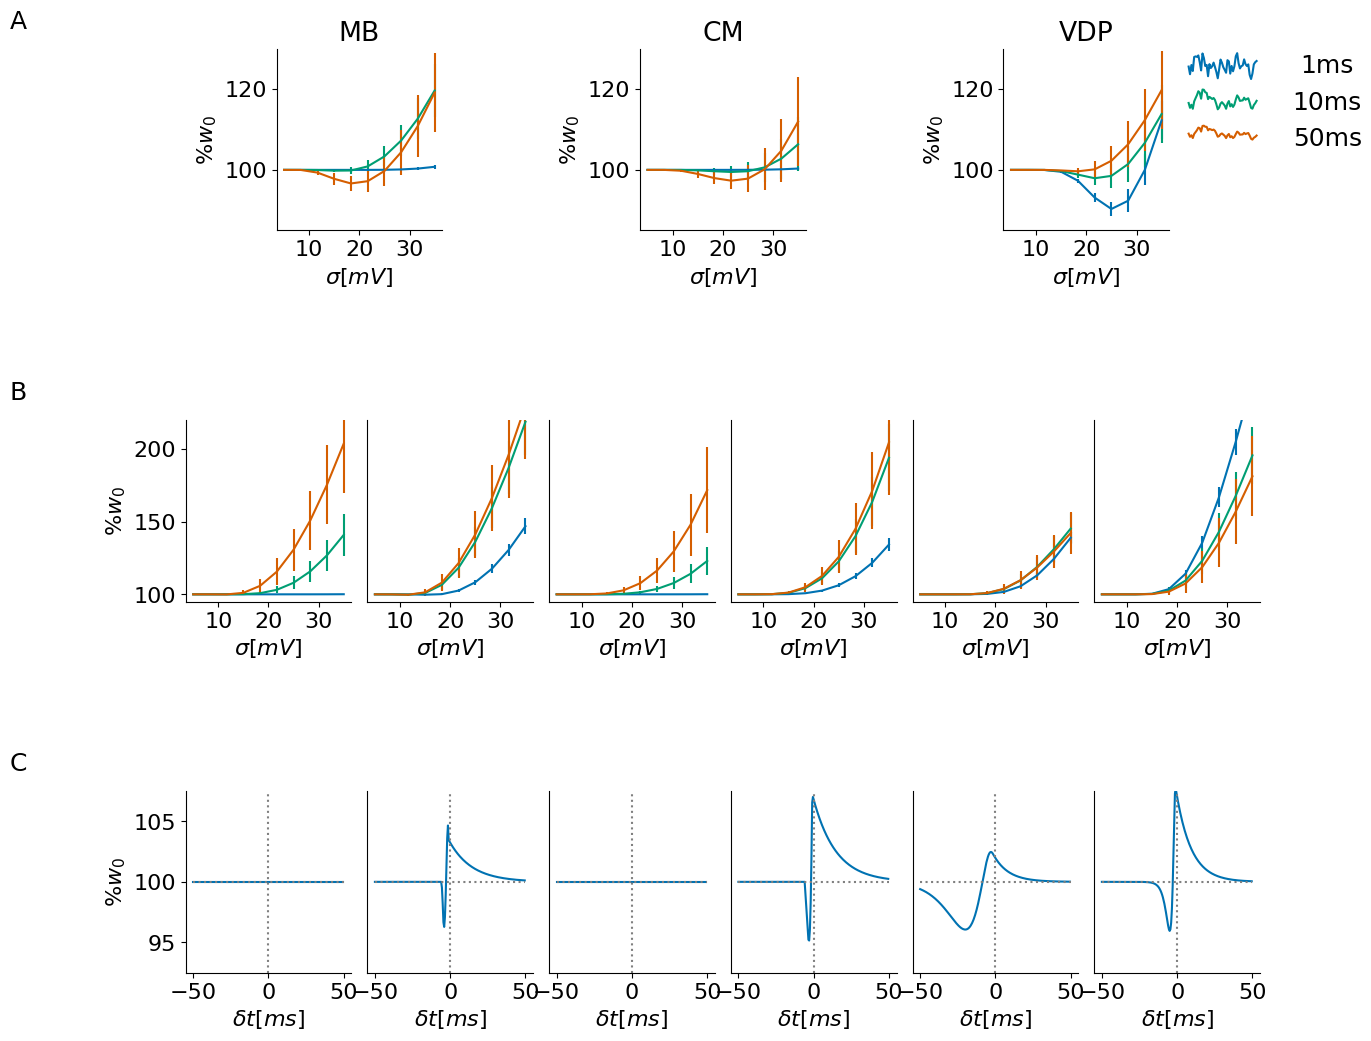

In [52]:

layout = '''
    AAAAAAAAAAAAA
    AAAAAAAAAAAAA
    BBBBBBBBBBBBB
    BBBBBBBBBBBBB
    CCCCCCCCCCCCC
    '''

fig = plt.figure(figsize=(16, 12))

height_ratios = [1,0.05,1, 0.05,1]
width_ratios = [1,.5,.5,.5,0.5,.5,.5,.5,0.5,.5,.5,.5,0.5]

specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABC':
    axes[letter] = ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABC', postfix='', offset_left=0.1)
for a in list('ABC'):
    axes[a].set_axis_off()
    

#plot for C
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  
ax = fig.add_subplot(gs[0,10:12])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, standard_vdp_results[i,:,0], yerr = standard_vdp_results[i,:,1])
ax.set_ylabel('$\% w_0$')
ax.set_xlabel('$\sigma[mV]$')
ax.set_title('VDP')
ax.set_ylim(85,130)
clear_axes(ax)

ax = fig.add_subplot(gs[2,9:11])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, slow_vdp_results[i,:,0], yerr = slow_vdp_results[i,:,1])
#ax.set_ylabel('$\% w_0$')
#ax.yaxis.tick_right()
ax.set_xlabel('$\sigma[mV]$')
ax.set_ylim(95,220)
ax.set_yticks([])
ax.set_yticklabels([])
clear_axes(ax)

#ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False) 

#STDP kernel
ax = fig.add_subplot(gs[4,9:11])
ax.plot(stdp_delays, (slow_vdp_k*repetitions*100/w_0)*100+100)
ax.set_ylim(92.5, 107.5)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')
ax.set_xlabel('$\delta t [ms]$')
ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_yticks([])
ax.set_yticklabels([])
clear_axes(ax)

ax = fig.add_subplot(gs[2,11:])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, fast_vdp_results[i,:,0], yerr = fast_vdp_results[i,:,1])
#ax.set_ylabel('$\% w_0$')
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
ax.set_xlabel('$\sigma[mV]$')
ax.set_ylim(95,220)
#ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False) 
#ax.set_ylabel('$\% w_0$')
ax.set_yticks([])
ax.set_yticklabels([])
clear_axes(ax)

#STDP kernel
ax = fig.add_subplot(gs[4,11:])
ax.plot(stdp_delays, (fast_vdp_k*repetitions*25/w_0)*100+100)
ax.set_ylim(92.5, 107.5)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')
ax.set_xlabel('$\delta t [ms]$')
ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_yticks([])
ax.set_yticklabels([])
clear_axes(ax)


#add a costum legend with examples of the process
ax = fig.add_subplot(gs[0,12:])
fromt = 100
tot = 150
for i in range(taus.shape[0]):
    normed_v_ex = v_example[i][0,fromt:tot]/ np.max(np.abs(v_example[i][0,fromt:tot]))
    ax.plot(normed_v_ex*0.5 +(3-i*0.5) )

    ax.text(100, (2.6-i*0.6), str(taus[i])+'ms', fontsize =18, ha='center')
ax.set_ylim(-0.0,3)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False) 
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
clear_axes(ax)


#plot for B
ax = fig.add_subplot(gs[0,6:8])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, standard_cl_results[i,:,0], yerr = standard_cl_results[i,:,1], label = taus[i])
ax.set_ylabel('$\% w_0$')
ax.set_xlabel('$\sigma[mV]$')
ax.set_title('CM')
ax.set_ylim(85,130)
clear_axes(ax)

ax = fig.add_subplot(gs[2,5:7])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, slow_cl_results[i,:,0], yerr = slow_cl_results[i,:,1])
#ax.set_ylabel('$\% w_0$')
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('$\sigma[mV]$')
ax.set_ylim(95,220)
clear_axes(ax)

#STDP kernel
ax = fig.add_subplot(gs[4,5:7])
ax.plot(stdp_delays, (slow_cl_k*repetitions/w_0)*100+100)
#ax.plot(stdp_delays, (slow_cl_kad*repetitions/w_0)*100+100, label = 'adapted $\\theta$', color = palette[2])
ax.set_ylim(92.5, 107.5)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')
ax.set_xlabel('$\delta t [ms]$')
ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_yticks([])
ax.set_yticklabels([])
clear_axes(ax)

ax = fig.add_subplot(gs[2,7:9])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, fast_cl_results[i,:,0], yerr = fast_cl_results[i,:,1])
#ax.set_ylabel('$\% w_0$')
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('$\sigma[mV]$')
ax.set_ylim(95,220)
clear_axes(ax)

#STDP kernel
ax = fig.add_subplot(gs[4,7:9])
ax.plot(stdp_delays, (fast_cl_k*repetitions/w_0)*100+100)
ax.set_ylim(92.5, 107.5)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')
ax.set_xlabel('$\delta t [ms]$')
ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_yticks([])
ax.set_yticklabels([])
clear_axes(ax)


ax = fig.add_subplot(gs[0,2:4])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, standard_mb_results[i,:,0], yerr = standard_mb_results[i,:,1], label = taus[i])
ax.set_ylabel('$\% w_0$')
ax.set_xlabel('$\sigma[mV]$')
ax.set_title('MB')
ax.set_ylim(85,130)
clear_axes(ax)

ax = fig.add_subplot(gs[2,1:3])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, slow_mb_results[i,:,0], yerr = slow_mb_results[i,:,1])
ax.set_ylabel('$\% w_0$')
ax.set_xlabel('$\sigma[mV]$')
ax.set_ylim(95,220)
clear_axes(ax)

#STDP kernel
ax = fig.add_subplot(gs[4,1:3])
ax.plot(stdp_delays, (slow_mb_k*repetitions/w_0)*100+100)
#ax.plot(stdp_delays, (slow_mb_kad*repetitions/w_0)*100+100, label = 'adapted $\\theta$', color = palette[2])
ax.set_ylim(92.5, 107.5)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')
ax.set_xlabel('$\delta t [ms]$')
ax.set_ylabel('$\% w_{0}$')
ax.ticklabel_format(useOffset=False, style = 'plain')
clear_axes(ax)

ax = fig.add_subplot(gs[2,3:5])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, fast_mb_results[i,:,0], yerr = fast_mb_results[i,:,1])
#ax.set_ylabel('$\% w_0$')
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('$\sigma[mV]$')
ax.set_ylim(95,220)
clear_axes(ax)

#STDP kernel
ax = fig.add_subplot(gs[4,3:5])
ax.plot(stdp_delays,(fast_mb_k*repetitions/2/w_0)*100+100)
ax.set_ylim(92.5, 107.5)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')
ax.set_xlabel('$\delta t [ms]$')
ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_yticks([])
ax.set_yticklabels([])
clear_axes(ax)


plt.savefig(figures_path+'fig2_subthreshold_fluctuations_nw.pdf', bbox_inches='tight')
plt.show()